In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import Sequential, ReLU, Module, Dropout, Sigmoid, Linear, BatchNorm2d
from torch.optim import Adam, RMSprop
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Grayscale, Resize, ToTensor, Normalize
import torch.nn.functional as F
import torchvision.utils as vutils
import pickle
import os
from PIL import Image
import cv2
import json

In [11]:
%cd /home/bcca/Desktop/Soham/DL Course Project/Handwritten-Equation-Solver/

/home/bcca/Desktop/Soham/DL Course Project/Handwritten-Equation-Solver


In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [13]:
from sklearn.model_selection import train_test_split
batch_size = 128
transformations = Compose([Grayscale(num_output_channels=1),
                           Resize((128,128)),
                           ToTensor()])

data = ImageFolder(root='../Handwritten-Equation-Solver/data/character_data',transform=transformations)

mapping = {}
for idx, (class_name, _) in enumerate(data.class_to_idx.items()):

    if(class_name[0]=='_' and class_name[2]=='_'):
        mapping[idx] = class_name[1]
    else:
        mapping[idx] = class_name
    data.classes[idx] = idx

train_data, val_data = train_test_split(data, test_size=0.3, shuffle=True)

with open('my_dict.json', 'w') as f:
    json.dump(mapping, f)

Image size = torch.Size([128, 1, 128, 128])
Label size = torch.Size([128])


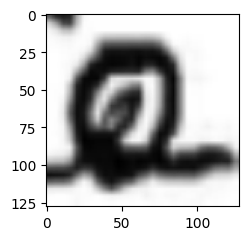

In [14]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

for i, (images, labels) in enumerate(train_loader):
    print("Image size =",images.shape)
    print("Label size =",labels.shape)
    img = images[0]
    plt.figure(figsize=(2.5,2.5))
    plt.imshow(img[0], cmap='gray')
    plt.show()
    break

In [15]:
class CharacterNet(Module):

    ''' CNN architecture for character recognition '''

    def __init__(self):

        super(CharacterNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.fc1 = nn.Linear(64 * 32 * 32, 512)
        # self.fc2 = nn.Linear(512, 36)
        self.fc = nn.Sequential(
            nn.Linear(64 * 32 * 32, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 36)
            # nn.ReLU()
        )



    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # x = self.dropout(x)
        # print(x.shape)              # torch.Size([128, 64, 32, 32])
        x = x.view(-1, 64 * 32 * 32)
        # x = F.relu(self.fc1(x))
        # x = self.fc2(x) 
        x = self.fc(x)
        x = F.softmax(x, dim=1)

        return x

In [26]:
# FGSM adversarial attack function
def fgsm_attack(data, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

# Adversarial training loop
def adversarial_train(model, device, train_loader, optimizer, criterion, epsilon,klm):

    model.train()
    running_loss = 0.0

    all_labels = []
    all_predictions = []

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)

        encoder = OneHotEncoder(categories=[data.classes])
        labels_encoded = encoder.fit_transform(labels.reshape(-1, 1)).toarray()
        labels_encoded = torch.Tensor(labels_encoded).to(device)

        images.requires_grad = True

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_encoded)
        loss.backward(retain_graph=True)  # Add retain_graph=True

        # Generate adversarial examples
        data_grad = images.grad.data
        perturbed_images = fgsm_attack(images, epsilon, data_grad)

        # Update model with both original and adversarial examples
        outputs_adv = model(perturbed_images)
        
        loss_adv = criterion(outputs_adv, labels_encoded)
        total_loss = loss + loss_adv
        factor = 1
        # factor = (6- (4*(klm-1)/49) )
        total_loss = total_loss*factor  # this should be remove

        total = labels.size(0)
        _, predicted = torch.max(outputs_adv.data, 1)
        _, expected = torch.max(labels_encoded, 1)
        correct = (predicted == expected).sum().item()

        all_labels.extend(list(expected.cpu().numpy()))
        all_predictions.extend(list(predicted.cpu().numpy()))

        running_loss += total_loss.item()
        total_loss.backward(retain_graph=True)  # Add retain_graph=True
        optimizer.step()  

    print('Loss:',running_loss/(factor*len(train_loader) ),end=" ") 
    print('Train accuracy:',sklearn.metrics.accuracy_score(all_labels, all_predictions), end=" ")

    
def adversarial_validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(list(labels.cpu().numpy()))
            all_predictions.extend(list(predicted.cpu().numpy()))

            running_loss += loss.item()

    print('Validation Loss:', running_loss / len(val_loader), end=" ")
    print('Validation Accuracy:', sklearn.metrics.accuracy_score(all_labels, all_predictions))
    return running_loss / len(val_loader)


model = CharacterNet().to(device)
num_epochs = 50
optimizer = Adam(model.parameters(), lr =0.001)
criterion = nn.CrossEntropyLoss()
epsilona = 0.3


klm = 0
                                                                                  # Training loop with adversarial training
for epoch in range(num_epochs):
    print("Epoch",epoch, end=" ")
    klm+=1
    adversarial_train(model, device, train_loader, optimizer, criterion, epsilona,klm)
    adversarial_validate(model, device, val_loader, criterion)

Epoch 0 Loss: 7.164811050891876 Train accuracy: 0.035919825362175035 Validation Loss: 3.547697431900922 Validation Accuracy: 0.05787037037037037
Epoch 1 Loss: 6.967765545845031 Train accuracy: 0.07501488390553682 Validation Loss: 3.302059299805585 Validation Accuracy: 0.3314814814814815
Epoch 2 Loss: 6.684283339977265 Train accuracy: 0.2051994443341933 Validation Loss: 3.250256019480088 Validation Accuracy: 0.3787037037037037
Epoch 3 Loss: 6.609284222126007 Train accuracy: 0.24786664020639015 Validation Loss: 3.2466236142551197 Validation Accuracy: 0.38425925925925924
Epoch 4 Loss: 6.4793134212493895 Train accuracy: 0.34947410200436596 Validation Loss: 3.2168745153090534 Validation Accuracy: 0.4148148148148148
Epoch 5 Loss: 6.416887128353119 Train accuracy: 0.3969041476483429 Validation Loss: 3.193792890099918 Validation Accuracy: 0.43472222222222223
Epoch 6 Loss: 6.453995656967163 Train accuracy: 0.3248660448501687 Validation Loss: 3.1644706024843106 Validation Accuracy: 0.46712962962

In [27]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = CharacterNet().to(device)
num_epochs = 50
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epsilona = 0.3

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


In [28]:
# Training loop with adversarial training
klm =0
# Training loop with adversarial training
for epoch in range(num_epochs):
    print("Epoch", epoch, end=" ")
    klm+=1
    # Train the model with adversarial training
    adversarial_train(model, device, train_loader, optimizer, criterion, epsilona, klm)

    # Validate the model
    validation_loss = adversarial_validate(model, device, val_loader, criterion)
    
    # Adjust learning rate based on validation loss
    scheduler.step(validation_loss)

Epoch 0 Loss: 7.1792832016944885 Train accuracy: 0.02579876959714229 Validation Loss: 3.579292255289414 Validation Accuracy: 0.043055555555555555
Epoch 1 Loss: 6.982596862316131 Train accuracy: 0.06965667791228418 Validation Loss: 3.2823162639842316 Validation Accuracy: 0.34814814814814815
Epoch 2 Loss: 6.559021353721619 Train accuracy: 0.295098233776543 Validation Loss: 3.1990568357355453 Validation Accuracy: 0.43425925925925923
Epoch 3 Loss: 6.38560825586319 Train accuracy: 0.4098035324469141 Validation Loss: 3.173128240248736 Validation Accuracy: 0.4625
Epoch 4 Loss: 6.320523965358734 Train accuracy: 0.45167692002381427 Validation Loss: 3.1561009883880615 Validation Accuracy: 0.4777777777777778
Epoch 5 Loss: 6.288581120967865 Train accuracy: 0.44810478269497916 Validation Loss: 3.1162932760575237 Validation Accuracy: 0.5180555555555556
Epoch 6 Loss: 6.181082189083099 Train accuracy: 0.5137924191307799 Validation Loss: 3.085892817553352 Validation Accuracy: 0.549074074074074
Epoch 7 

In [31]:
model_path = "ScheduledCharacterNet_model.pth"

# Save the model state dictionary
torch.save(model.state_dict(), model_path)

## Validation

In [35]:
count = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(images)):
            total += 1
            img = images[i].cpu().numpy()
            pred = predicted[i].cpu().item()
            label = labels[i].cpu().item()

            if(label == pred):
                count += 1
        break

print("Accuracy =",count/total)

Accuracy = 0.8046875


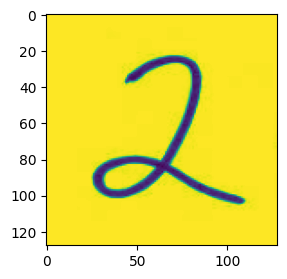

multiply


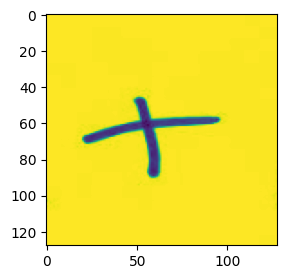

t


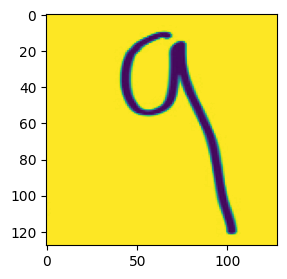

n


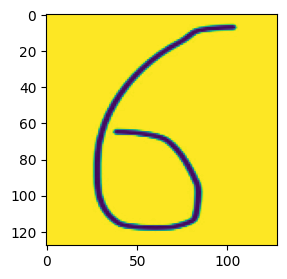

5


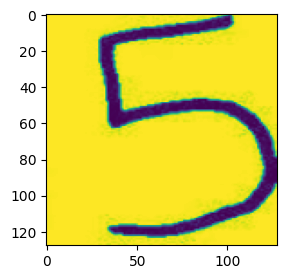

8


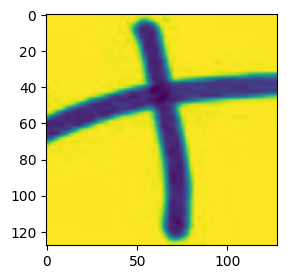

add


In [33]:
for i in range(5,7):

    ii = cv2.imread('../Handwritten-Equation-Solver/test_data/'+ str(i) + '.jpeg')
    gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (128,128))
    gray_image = gray_image.reshape((1,128,128))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    print(mapping[predicted.cpu().numpy()[0]])

for i in range(7,9):

    ii = cv2.imread('../Handwritten-Equation-Solver/test_data/'+ str(i) + '.png')
    gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (128,128))
    gray_image = gray_image.reshape((1,128,128))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    print(mapping[predicted.cpu().numpy()[0]])

for i in range(9,11):

    ii = cv2.imread('../Handwritten-Equation-Solver/test_data/'+ str(i) + '.jpeg')
    gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (128,128))
    gray_image = gray_image.reshape((1,128,128))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    print(mapping[predicted.cpu().numpy()[0]])

In [34]:
torch.save(model.state_dict(), 'AdversarialCharacterNet.pth')